## Visualize the decision of the classifier
In this notebook I will show how to use Class Acvitation Maps (CAM) (https://arxiv.org/abs/1512.04150). <br />
A method to visualize image regions most important for the decision of the classifier.

## Imports

* torch for tensor manipulation
* torchvision for resnet18
* transforms for Normalization
* pytorch lightning for model creation
* numpy for data loading
* matplotlib for plotting

In [1]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

The dataset of the previous notebook is used.

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)


In [3]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),

])

val_dataset = torchvision.datasets.DatasetFolder("./Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

The key idea of CAM is to multiply the output of the last convolutional layer (BasicBlock 1 of layer 4) $A_k$ (consisting of k channels) with the parameters $w$ of the subsequent fully connected layer to compute an activation map $M$:
$$ M = \sum_k w_kA_k$$

To do so, I need to access this particular output of the trained resnet50.<br />
Let's recap the resnet architecture:

In [4]:
temp_model = torchvision.models.resnet50()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

I can convert the network to a generator using the **children()** function.<br />
This means that I can use the list function to convert it into a list!<br />
The convolutional part of the network comprises all layers up to the AdaptiveAvgPool2d layer.

In [5]:
list(temp_model.children())[:-2]  # get all layers up to avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

Using **Sequential** from pytorch, we convert the list of layers back to a Sequential Model.


In [6]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Now I am ready to go.<br />
I add an additional output to the forward function of our pneumonia model, to return the **feature maps** of the last convolutional layer ($A$)

I extract the feature map in the forward pass, followed by global average pooling and flattening.
Finally I use the fully connected layer to compute the final class prediction.

In [7]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet50()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet50) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])   
        
    def forward(self, data):
        # To cimpute preidction: 
        # 1st: Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape) # compresses it in (1x1x2048)
        # Flatten the output into a 2048 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output) # create a vector of 2048
        print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    


In [8]:
# strict=False: because in the original trained model, we have not weights for the feature_map layer
# So, without strict=False, this will give us error (as there are not trained weights for feature_map layer) 
# Passing strict=False, it will load all weights it can match, and ignores the rest 
import warnings
warnings.filterwarnings("ignore")

model = PneumoniaModel.load_from_checkpoint("./logs/lightning_logs/version_0/checkpoints/epoch=29-step=5640.ckpt", strict=False)
model.eval();

In [9]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    # the features have the sahpe 2048x7x7
    # reshaping them (to get 2D matrix)
    features = features.reshape((2048, 49))
    # model is an object of the Class PneumoniaModel
    # Then, we access the model defined in the initialization function in the class PneumoniaModel  
    weight_params = list(model.model.fc.parameters())[0] # [0]: we are interrested in the weights (not bias) 
    # Now weight_params contains an array of 2048 elements
    # Now, we should remove the gradient information from the weight_params to enable numpy conversion
    # And with [0], we remove Batch size axis
    weight = weight_params[0].detach()
    
    # Cimpute Class Activation Map : (2048) x (2048,49) ==> 49
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    
    return cam_img, torch.sigmoid(pred)

## CAM
Now I can define the CAM function by using the formula from above:

In [10]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 2048x7x7 feature tensor into a 2048x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))
    
    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0] 
    
    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)
    
    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################
    
    # Normalize and standardize the class activation map (Not always necessary)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]
    
    # Create a figure
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [11]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

## Demo Time

In [12]:
img = val_dataset[-6][0]  # Select a subject & remove BS dimension
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([1, 2048, 1, 1])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 49])


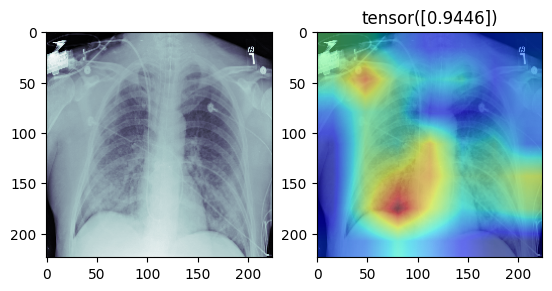

In [13]:
visualize(img, activation_map, pred)  # Visualize CAM

The heatmap focuses on the area which shows signs of pneumonia

We can try out this method for all neural networks with one restriction: The classic CAM algorithm requrires a specific network architecture:<br />
Last Convolution $\rightarrow$ Global Average Pool $\rightarrow$ 1 FC Layer.

For other network architectures, we either need to adapt the architecture, followed by retraining our use different methods such as GradCAM or ScoreCAM (https://arxiv.org/abs/1610.02391), (https://arxiv.org/abs/1910.01279)